# **Evaluate LLM Judge FT**

In this notebook, we focus on **evaluating the fine-tuned LLM Judge**. This involves displaying the training results, plotting validation loss, getting predictions from the test set, evaluating model performance, and conducting error analysis.

### Objectives:
- **Display Training Results:** Load and display the results from the fine-tuning job.
- **Plot Validation Loss:** Plot the validation loss over epochs to visualize the training process.
- **Get Predictions:** Use the fine-tuned model to get predictions on the test set.
- **Evaluate Performance:** Evaluate the model's performance using various metrics.
- **Error Analysis:** Analyze the errors made by the model to identify areas for improvement.

### Key Steps:
1. **Display Training Results:** Load and display the results from the fine-tuning job.
2. **Plot Validation Loss:** Plot the validation loss over epochs.
3. **Get Predictions:** Use the fine-tuned model to get predictions on the test set.
4. **Evaluate Performance:** Evaluate the model's performance using metrics such as accuracy, precision, recall, F1 score, and confusion matrix.
5. **Error Analysis:** Analyze the errors made by the model, including plotting mismatches and conducting cluster analysis.

This notebook ensures that the fine-tuned LLM Judge is evaluated effectively, providing insights into its performance and areas for improvement.

### **Display Training Results**

In [1]:
import json
import os
import dotenv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, cohen_kappa_score,
    classification_report
)

plt.style.use('ggplot')
sns.set_context("talk")  # Increase font sizes

In [2]:
# path to fine-tuning job results file
# can be downloaded from AI Foundry or Azure OpenAI Studio
path = "data/ft-judge/single/file-1723b618431d4226a7cd2f74fa59d5a8.csv"

df_training_res = pd.read_csv(path)
df_training_res.tail(1)

,step,train_loss,train_mean_token_accuracy,train_error_rate,valid_loss,valid_mean_token_accuracy,valid_error_rate,full_valid_loss,full_valid_mean_token_accuracy,full_valid_error_rate,rollout.reward/grade,test_set/mean_reward
1755,1756,0.243235,0.892857,NaN,0.631695,0.826087,NaN,0.485863,0.606905,NaN,NaN,NaN


#### **Plot the validation loss over epochs**

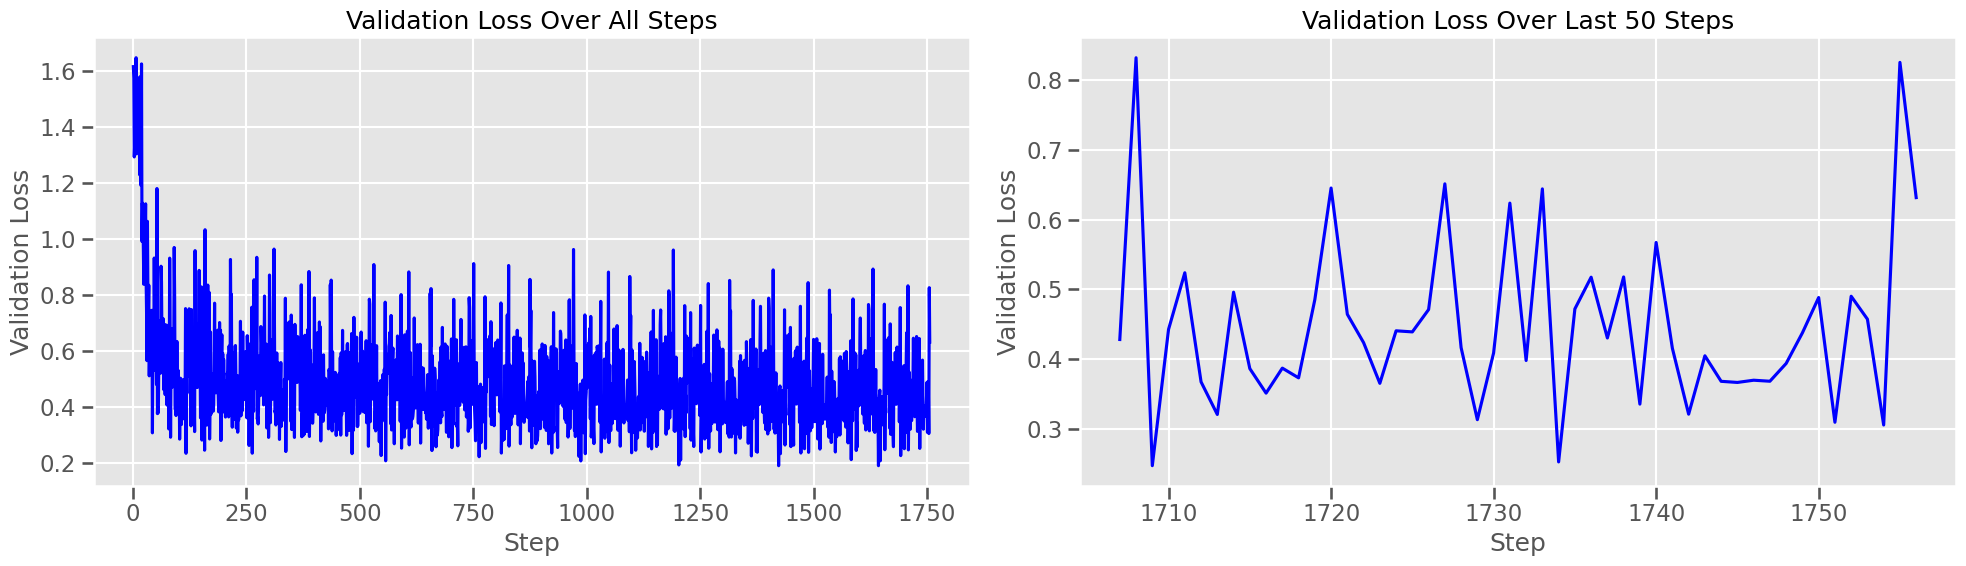

In [3]:
import matplotlib.pyplot as plt

last_n_steps = df_training_res.tail(50)

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

axs[0].plot(df_training_res['step'], df_training_res['valid_loss'], linestyle='-', color='b')
axs[0].set_title('Validation Loss Over All Steps')
axs[0].set_xlabel('Step')
axs[0].set_ylabel('Validation Loss')
axs[0].grid(True)

axs[1].plot(last_n_steps['step'], last_n_steps['valid_loss'], linestyle='-', color='b')
axs[1].set_title('Validation Loss Over Last 50 Steps')
axs[1].set_xlabel('Step')
axs[1].set_ylabel('Validation Loss')
axs[1].grid(True)

plt.tight_layout()
plt.show()

### **Get predictions from testset**

In [4]:
# !pip install azure-ai-evaluation==1.0.1 azure-ai-inference azure-ai-projects

In [ ]:
dotenv.load_dotenv(".env")

aoai_endpoint=os.getenv("AZURE_OPENAI_API_BASE")
aoai_api_key=os.getenv("AZURE_OPENAI_API_KEY")
aoai_chat_model_mini=os.getenv("AZURE_OPENAI_MODEL_MINI")
llm_judge=os.getenv("LLM_JUDGE")
aoai_api_version=os.getenv("AZURE_OPENAI_API_VERSION")

In [6]:
def get_model_config(eval_model=llm_judge):
    return {
        "azure_endpoint": aoai_endpoint,
        "api_key": aoai_api_key,
        "azure_deployment": eval_model,
        "api_version": aoai_api_version
    }

In [7]:
from evaluators.aoai.custom_groundedness import CustomGroundednessEvaluator

def run_custom_groundness_evaluator(
    query: any,
    context: any,
    response: any,
    model: str = llm_judge
):
    # loading key, endpoint, and version from .env file
    model_config = get_model_config(eval_model=model)

    # creating a class instance
    groundedness_eval = CustomGroundednessEvaluator(model_config=model_config)
    groundedness_score = groundedness_eval(
        query=query,
        context=context,
        response=response
    )

    return groundedness_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\povelf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
from tqdm import tqdm

def get_predictions(df, model=llm_judge):
    """
    Process each sample in the provided DataFrame using the custom groundness evaluator,
    and display a single updating progress bar.

    Parameters:
        df (pandas.DataFrame): DataFrame containing the following columns:
            - 'synthetic_question': The question text.
            - 'chunk_data': The associated chunk of information.
            - 'is_grounded': The ground-truth label.

    Returns:
        list: A list of evaluation results from the custom groundness evaluator.
    """
    scores = []
    total_iterations = len(df)
    
    with tqdm(total=total_iterations, desc="evaluating samples") as pbar:
        for i, row in df.iterrows():
            result = run_custom_groundness_evaluator(
                query=row["synthetic_question"],
                context=row["chunk_data"],
                response=row["synthetic_response"],
                model=model
            )
            scores.append({
                "chunk_id": row["chunk_id"],
                "result": result                
            })
            
            # Update the progress bar's postfix with additional information.
            pbar.set_postfix({
                "sample": i,
                "predicted label": result.get("label", "N/A"),
                "ground truth label": row["is_grounded"]
            })
            
            pbar.update(1)
    
    return scores


In [9]:
fpath='data/ft-judge/single/test.csv'
test_data = pd.read_csv(fpath)
test_data.head(1)

,synthetic_question,explanation,synthetic_response,chunk_id,is_grounded,chunk_data,aggregated_context,domain,difficulty,tone,language,question_length,synthetic_embedding
0,"What item did Emily purchase on April 2, 2023?",The question asks for the item Emily purchased...,Emily purchased a BaseCamp Folding Table on Ap...,252167c94bb6_aHR0cHM6Ly9zdG9yYWdlcG92ZWwuYmxvY...,True,## Customer_Info\n\nFirst Name: Emily \nLast N...,single chunk was used,Technical specifications,Beginner,Casual,English,11,"[-0.044192470610141754, 0.018508531153202057, ..."


In [10]:
judge_predictions = get_predictions(test_data, llm_judge)
vanilla_predictions = get_predictions(test_data, aoai_chat_model_mini)

evaluating samples: 100%|██████████| 219/219 [04:18<00:00,  1.18s/it, sample=218, predicted label=N/A, ground truth label=1]


### **Evaluate model performance**

In [11]:
def validate_data(all_scores):
    """
    Validate that the 'all_scores' dict contains proper keys and shapes.
    Returns predictions and ground_truth as NumPy arrays.
    """
    # Check that required keys are present
    required_keys = ["llm_scores", "ground_truth"]
    for key in required_keys:
        if key not in all_scores:
            raise KeyError(f"Missing key '{key}' in all_scores.")
    
    # Convert to NumPy arrays for consistency
    predictions = np.array(all_scores["llm_scores"])
    ground_truth = np.array(all_scores["ground_truth"])

    # Check that both are 1D arrays of same length
    if predictions.shape[0] != ground_truth.shape[0]:
        raise ValueError("Predictions and ground_truth must have the same length.")
    
    # Ground truth must be strictly 0/1 for binary classification
    unique_gt = np.unique(ground_truth)
    if not np.all(np.isin(unique_gt, [0, 1])):
        raise ValueError("ground_truth must contain only 0 or 1 for binary classification.")
    
    return predictions, ground_truth

In [12]:
def compute_metrics(ground_truth, hard_preds):
    """
    Compute standard classification metrics for binary classification.
    Returns a dict with accuracy, precision, recall, f1, kappa, and classification_report.
    """
    metrics = {}
    metrics["accuracy"] = accuracy_score(ground_truth, hard_preds)
    metrics["precision"] = precision_score(ground_truth, hard_preds, pos_label=1)
    metrics["recall"] = recall_score(ground_truth, hard_preds, pos_label=1)
    metrics["f1_score"] = f1_score(ground_truth, hard_preds, pos_label=1)
    metrics["kappa"] = cohen_kappa_score(ground_truth, hard_preds)
    metrics["classification_report"] = classification_report(ground_truth, hard_preds)
    return metrics

In [13]:
def print_metrics(metrics, model_name):
    """
    Print out the metrics dictionary with proper formatting.
    """
    print(f"=== Metrics for {model_name} ===")
    for key, value in metrics.items():
        if key != "classification_report":
            print(f"{key}: {value:.3f}")
        else:
            print("Classification Report:")
            print(value)

In [14]:
def plot_confusion_matrices(conf_matrix1, conf_matrix2,
                            model1_name, model2_name,
                            labels=("Negative", "Positive"),
                            figsize=(14, 6)):
    """
    Plot two confusion matrices side by side.
    
    Parameters:
      - conf_matrix1 (array-like): 2x2 confusion matrix for model 1.
      - conf_matrix2 (array-like): 2x2 confusion matrix for model 2.
      - model1_name (str): Name for model 1.
      - model2_name (str): Name for model 2.
      - labels (tuple): Labels for the x and y axes (default: ("Negative", "Positive")).
    """
    # Define the fixed cell labels for a 2x2 confusion matrix.
    cell_labels = np.array([["TN", "FP"],
                            ["FN", "TP"]])
    
    # Create a mapping from each cell label to a numeric code.
    mapping = {"TN": 0, "FP": 1, "FN": 2, "TP": 3}
    
    # Build a numeric matrix that encodes the quadrant positions.
    # This matrix is only used to paint the background with fixed colors.
    numeric_matrix = np.array([
        [mapping[cell_labels[0, 0]], mapping[cell_labels[0, 1]]],
        [mapping[cell_labels[1, 0]], mapping[cell_labels[1, 1]]]
    ])
    
    # Get a discrete version of the YlGnBu colormap with 4 discrete colors!!!!!!!!!!!!!!!!!!!!
    cmap_fixed = plt.get_cmap('YlGnBu', 4)
    
    # Create the figure and subplots.
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    ax1, ax2 = axes[0], axes[1]
    
    # Plot the fixed numeric matrix on both axes
    ax1.imshow(numeric_matrix, cmap=cmap_fixed, aspect="equal", interpolation='nearest')
    ax2.imshow(numeric_matrix, cmap=cmap_fixed, aspect="equal", interpolation='nearest')
    
    # Disable grid lines
    ax1.grid(False)
    ax2.grid(False)
    
    # Set the text color
    text_color = "#223333" # Dark gray
    text_color = "black"
    
    # Overlay the actual confusion matrix numbers and quadrant labels.
    for i in range(2):
        for j in range(2):
            ax1.text(j, i, f"{conf_matrix1[i, j]}\n({cell_labels[i, j]})",
                     ha="center", va="center", fontsize=14, color=text_color)
            ax2.text(j, i, f"{conf_matrix2[i, j]}\n({cell_labels[i, j]})",
                     ha="center", va="center", fontsize=14, color=text_color)
    
    # Configure the axis ticks, labels, and titles.
    for ax, name in zip([ax1, ax2], [model1_name, model2_name]):
        ax.set_xticks(np.arange(2))
        ax.set_xticklabels(labels, fontsize=16)
        ax.set_yticks(np.arange(2))
        ax.set_yticklabels(labels, fontsize=16)
        ax.set_xlabel("Predicted", fontsize=16)
        ax.set_ylabel("Actual", fontsize=16)
        ax.set_title(f"Confusion Matrix - {name}", fontsize=18)
    
    plt.tight_layout()
    plt.show()


In [15]:
def compare_llm_models(test_data, model1_predictions, model2_predictions,
                       model1_name="LLM Judge", model2_name="Regular LLM"):
    """
    Compare predictions from two models side by side against the ground truth.
    
    Parameters:
        test_data (pandas.DataFrame): Test data with a column 'is_grounded' (0/1).
        model1_predictions (list): List of dictionaries with key 'score' from model 1.
        model2_predictions (list): List of dictionaries with key 'score' from model 2.
        model1_name (str): Name for model 1.
        model2_name (str): Name for model 2.
        
    Returns:
        dict: A dictionary containing metrics for both models.
    """
    # Build all_scores dictionaries for each model
    all_scores_model1 = {"llm_scores": [], "ground_truth": []}
    all_scores_model2 = {"llm_scores": [], "ground_truth": []}
    
    for i in range(len(test_data)):
        # Assume that each prediction is a dictionary with a 'score' key
        all_scores_model1["llm_scores"].append(model1_predictions[i]["result"]["score"])
        all_scores_model1["ground_truth"].append(test_data.iloc[i]["is_grounded"])
        
        all_scores_model2["llm_scores"].append(model2_predictions[i]["result"]["score"])
        all_scores_model2["ground_truth"].append(test_data.iloc[i]["is_grounded"])
    
    # Validate and extract predictions and ground truth
    predictions1, ground_truth = validate_data(all_scores_model1)
    predictions2, _ = validate_data(all_scores_model2)
    ground_truth = ground_truth.astype(int) # Ensure ground truth is 0/1, and not True/False
    
    # Compute metrics for both models
    metrics1 = compute_metrics(ground_truth, predictions1)
    metrics2 = compute_metrics(ground_truth, predictions2)
    
    # Create side-by-side confusion matrix plots with annotations
    conf_matrix1 = confusion_matrix(ground_truth, predictions1)
    conf_matrix2 = confusion_matrix(ground_truth, predictions2)

    # Log the metrics
    print_metrics(metrics1, model1_name)
    print_metrics(metrics2, model2_name)


    # Call the new plot function for side-by-side confusion matrices
    plot_confusion_matrices(conf_matrix1, conf_matrix2, model1_name, model2_name)

    return {model1_name: metrics1, model2_name: metrics2}

=== Metrics for LLM Judge ===
accuracy: 0.991
precision: 0.991
recall: 0.991
f1_score: 0.991
kappa: 0.982
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       105
           1       0.99      0.99      0.99       114

    accuracy                           0.99       219
   macro avg       0.99      0.99      0.99       219
weighted avg       0.99      0.99      0.99       219

=== Metrics for Regular LLM ===
accuracy: 0.959
precision: 0.927
recall: 1.000
f1_score: 0.962
kappa: 0.917
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.96       105
           1       0.93      1.00      0.96       114

    accuracy                           0.96       219
   macro avg       0.96      0.96      0.96       219
weighted avg       0.96      0.96      0.96       219



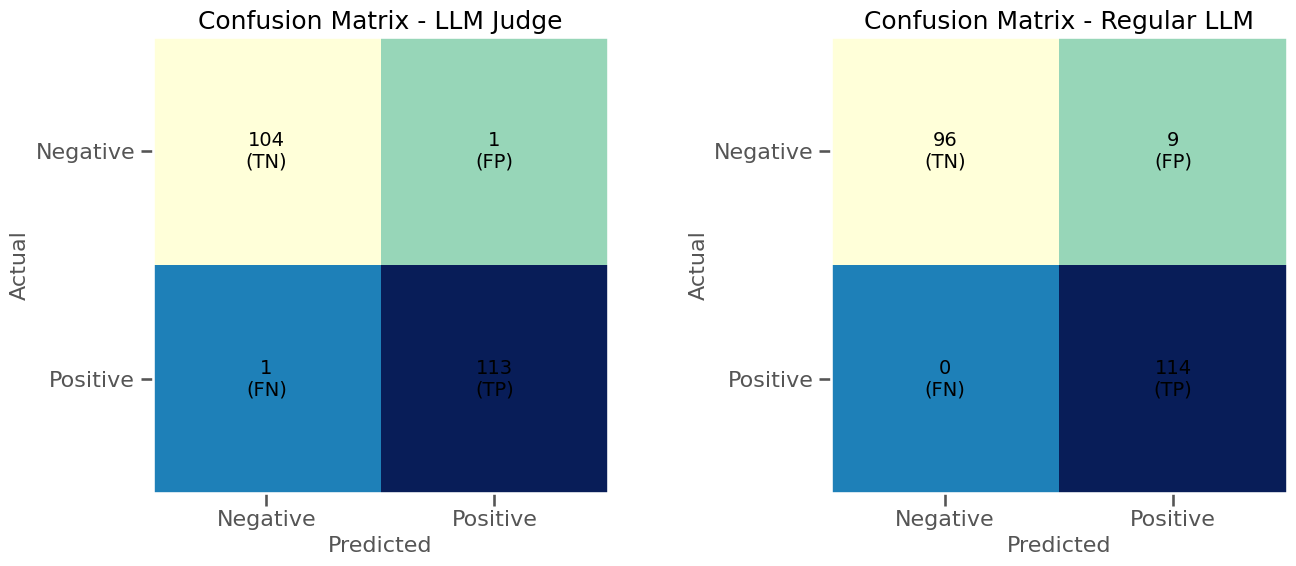

In [16]:
metrics_comparison = compare_llm_models(
    test_data, judge_predictions, vanilla_predictions,
    model1_name="LLM Judge", model2_name="Regular LLM"
)

### **Error Analysis**

**compute mistaches**

In [17]:
def parse_result(result):
    """
    Helper function to parse the result field.
    If result is a JSON string, this attempts to parse it.
    If it's already a dict, it returns it as-is.
    """
    if isinstance(result, str):
        try:
            return json.loads(result)
        except Exception:
            return {}
    elif isinstance(result, dict):
        return result
    return {}

def process_predictions(predictions_list, test_data):
    """
    Converts a predictions list into a merged DataFrame with ground truth information.
    Assumes predictions_list is a list of dictionaries with a unique 'chunk_id' per test sample.
    """
    # Convert the list of predictions into a DataFrame.
    df_pred = pd.DataFrame(predictions_list)
    
    # Parse the 'result' field so we can extract the label.
    df_pred['parsed_result'] = df_pred['result'].apply(parse_result)
    
    # Create a boolean column from the parsed result.
    df_pred['predicted_label_bool'] = df_pred['parsed_result'].apply(
        lambda x: True if x.get('score') == 1 else False if x.get('score') == 0 else None
    )
    
    # Merge with the test_data DataFrame on 'chunk_id'
    merged_df = df_pred.merge(test_data[['chunk_id', 'is_grounded', 'difficulty', 'domain', 'synthetic_embedding']], on='chunk_id', how='left')
    return merged_df

def get_mismatch_df(merged_df, pred_col='predicted_label_bool', truth_col='is_grounded'):
    """
    Returns a DataFrame containing only the rows where the prediction does not match the ground truth.
    """
    # You might want to treat None as a mismatch as well.
    mismatch_df = merged_df[merged_df[pred_col] != merged_df[truth_col]]
    return mismatch_df

def compute_mismatches(vanilla_predictions, judge_predictions, test_data):
    """
    Processes both vanilla and judge predictions and returns DataFrames containing only the mismatches
    compared to the test data.
    """
    # Process vanilla predictions
    vanilla_merged = process_predictions(vanilla_predictions, test_data)
    vanilla_mismatches = get_mismatch_df(vanilla_merged)
    
    # Process judge predictions
    judge_merged = process_predictions(judge_predictions, test_data)
    judge_mismatches = get_mismatch_df(judge_merged)
    
    return {"vanilla": vanilla_mismatches, "judge": judge_mismatches}

mismatches = compute_mismatches(vanilla_predictions, judge_predictions, test_data)


In [23]:
mismatches["vanilla"]

,chunk_id,result,parsed_result,predicted_label_bool,is_grounded,difficulty,domain,synthetic_embedding
41,252167c94bb6_aHR0cHM6Ly9zdG9yYWdlcG92ZWwuYmxvY...,"{'score': 1, 'explanation': 'The chunk clearly...","{'score': 1, 'explanation': 'The chunk clearly...",True,False,Beginner,Usage instructions,"[-0.02750384621322155, -0.005629627499729395, ..."
114,252167c94bb6_aHR0cHM6Ly9zdG9yYWdlcG92ZWwuYmxvY...,"{'score': 1, 'explanation': 'The chunk provide...","{'score': 1, 'explanation': 'The chunk provide...",True,False,Advanced,Usage instructions,"[-0.02524607628583908, 0.0021290185395628214, ..."
121,252167c94bb6_aHR0cHM6Ly9zdG9yYWdlcG92ZWwuYmxvY...,"{'score': 1, 'explanation': 'The chunk provide...","{'score': 1, 'explanation': 'The chunk provide...",True,False,Advanced,Product Description,"[-0.020829830318689346, 0.008331932127475739, ..."
131,c34dafd3cd3a_aHR0cHM6Ly9zdG9yYWdlcG92ZWwuYmxvY...,"{'score': 1, 'explanation': 'The chunk provide...","{'score': 1, 'explanation': 'The chunk provide...",True,False,Beginner,Product Description,"[0.021803105250000954, -0.04258846864104271, -..."
135,c34dafd3cd3a_aHR0cHM6Ly9zdG9yYWdlcG92ZWwuYmxvY...,"{'score': 1, 'explanation': 'The chunk provide...","{'score': 1, 'explanation': 'The chunk provide...",True,False,Advanced,Usage instructions,"[-0.03847866505384445, -0.05116141960024834, -..."
162,c34dafd3cd3a_aHR0cHM6Ly9zdG9yYWdlcG92ZWwuYmxvY...,"{'score': 1, 'explanation': 'The chunk provide...","{'score': 1, 'explanation': 'The chunk provide...",True,False,Expert,Technical specifications,"[-0.02190079540014267, -0.005233596079051495, ..."
199,c34dafd3cd3a_aHR0cHM6Ly9zdG9yYWdlcG92ZWwuYmxvY...,"{'score': 1, 'explanation': 'The agent respons...","{'score': 1, 'explanation': 'The agent respons...",True,False,Expert,Product Description,"[-0.013364439830183983, -0.009120073169469833,..."
208,c34dafd3cd3a_aHR0cHM6Ly9zdG9yYWdlcG92ZWwuYmxvY...,"{'score': 1, 'explanation': 'The chunk provide...","{'score': 1, 'explanation': 'The chunk provide...",True,False,Advanced,Usage instructions,"[-0.010302795097231865, 0.0060883271507918835,..."
216,c34dafd3cd3a_aHR0cHM6Ly9zdG9yYWdlcG92ZWwuYmxvY...,"{'score': 1, 'explanation': 'The chunk contain...","{'score': 1, 'explanation': 'The chunk contain...",True,False,Intermediate,Customer reviews,"[-0.04103519022464752, -0.024521028622984886, ..."


In [ ]:
mismatches["judge"]

,chunk_id,result,parsed_result,predicted_label_bool,is_grounded,difficulty,domain,synthetic_embedding
41,252167c94bb6_aHR0cHM6Ly9zdG9yYWdlcG92ZWwuYmxvY...,"{'score': 1, 'explanation': 'The question is g...","{'score': 1, 'explanation': 'The question is g...",True,False,Beginner,Usage instructions,"[-0.02750384621322155, -0.005629627499729395, ..."
215,252167c94bb6_aHR0cHM6Ly9zdG9yYWdlcG92ZWwuYmxvY...,"{'score': 0, 'explanation': 'The provided chun...","{'score': 0, 'explanation': 'The provided chun...",False,True,Expert,Customer reviews,"[-0.029712064191699028, 0.00522045511752367, -..."


**plotting mismatches**

In [18]:
def cluster_analysis_dual_pca(df1, df2, metadata_col="difficulty"):
    """
    Runs PCA on two DataFrames (df1 and df2) containing a column 'synthetic_embedding' and a metadata column (specified by metadata_col).
    If only one sample exists in a DataFrame, a dummy sample is added along with a duplicate of its metadata.
    
    Parameters:
        df1 (pd.DataFrame): First DataFrame (e.g., vanilla mismatches).
        df2 (pd.DataFrame): Second DataFrame (e.g., judge mismatches).
        metadata_col (str): Name of the metadata column to be used for coloring.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Process both dataframes
    for i, (df, title) in enumerate([
        (df1, "Vanilla Mismatches"), 
        (df2, "Judge Mismatches")
    ]):
        DUMMY_DATA = False
        synthetic_embeddings = []

        # Convert string representations of embeddings into numpy arrays.
        for j in range(len(df)):
            embedding_str = df['synthetic_embedding'].iloc[j]
            try:
                # Parse the string to a list and then convert to a numpy array.
                embedding_list = ast.literal_eval(embedding_str)
                embedding_array = np.array(embedding_list, dtype=np.float32)
                synthetic_embeddings.append(embedding_array)
            except Exception as e:
                print(f"Error parsing embedding at index {j} in {title}: {embedding_str}. Exception: {e}")
        
        # If no samples, display a message on the subplot.
        if len(synthetic_embeddings) == 0:
            print(f"No samples for {title}.")
            axes[i].set_title(f"{title} (No Data)")
            axes[i].text(0.5, 0.5, "No data available",
                         horizontalalignment='center',
                         verticalalignment='center',
                         transform=axes[i].transAxes)
            continue
        
        # If only one sample is present, add a dummy sample.
        if len(synthetic_embeddings) == 1:
            print(f"Only one sample available for {title}, adding a dummy sample for PCA.")
            dummy_embedding = synthetic_embeddings[0]
            synthetic_embeddings.append(dummy_embedding)
            DUMMY_DATA = True
        
        # Stack the embeddings into a 2D array.
        synthetic_embeddings_array = np.vstack(synthetic_embeddings)
        
        # Run PCA to reduce the embeddings to 2 dimensions.
        pca = PCA(n_components=2, random_state=23)
        pca_results = pca.fit_transform(synthetic_embeddings_array)
        
        # Create a DataFrame with PCA results.
        df_pca = pd.DataFrame({
            'pc1': pca_results[:, 0],
            'pc2': pca_results[:, 1]
        })
        
        # Handle metadata: duplicate if a dummy sample was added.
        if DUMMY_DATA:
            df_meta = pd.DataFrame([df.iloc[0]] * 2).reset_index(drop=True)
        else:
            df_meta = df.reset_index(drop=True)
        
        # Combine PCA results with the metadata.
        df_combined = pd.concat([df_pca, df_meta], axis=1)
        
        # Plot the PCA results.
        sns.scatterplot(data=df_combined, x='pc1', y='pc2', hue=metadata_col, ax=axes[i])
        axes[i].set_title(f"PCA Clustering of {title} by '{metadata_col}'")
    
    plt.tight_layout()
    plt.show()


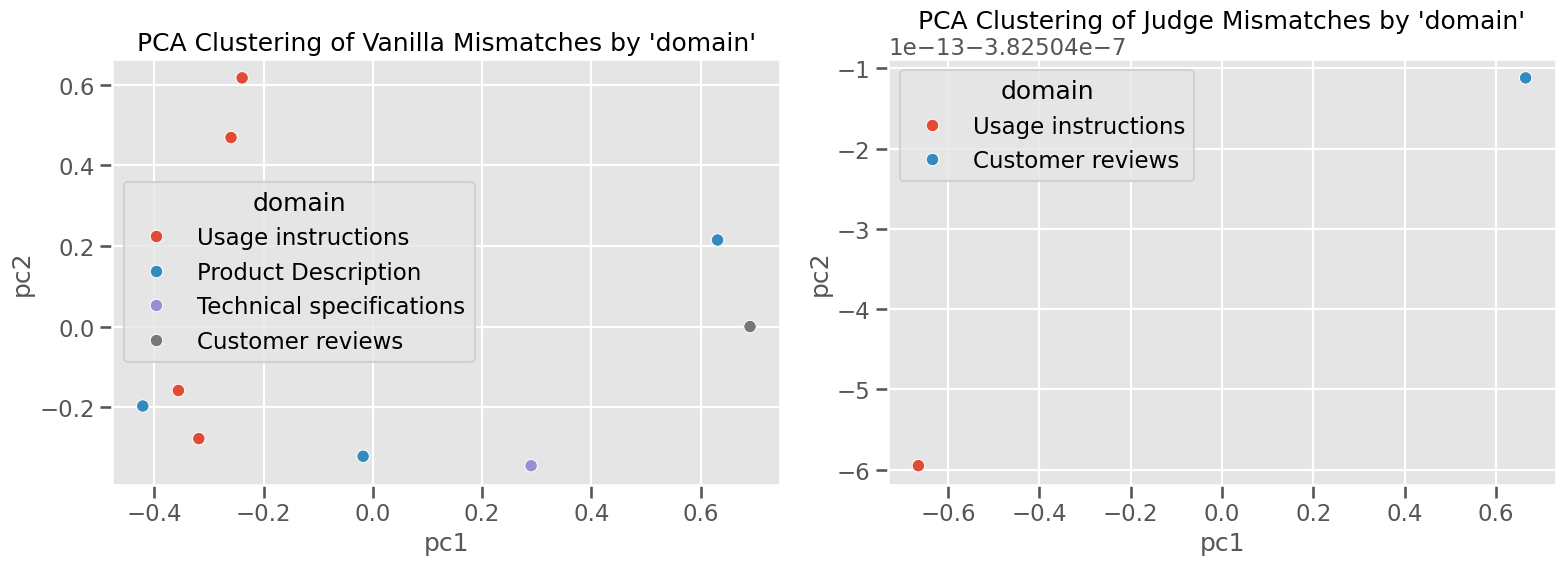

In [19]:
cluster_analysis_dual_pca(mismatches["vanilla"], mismatches["judge"], metadata_col="domain")

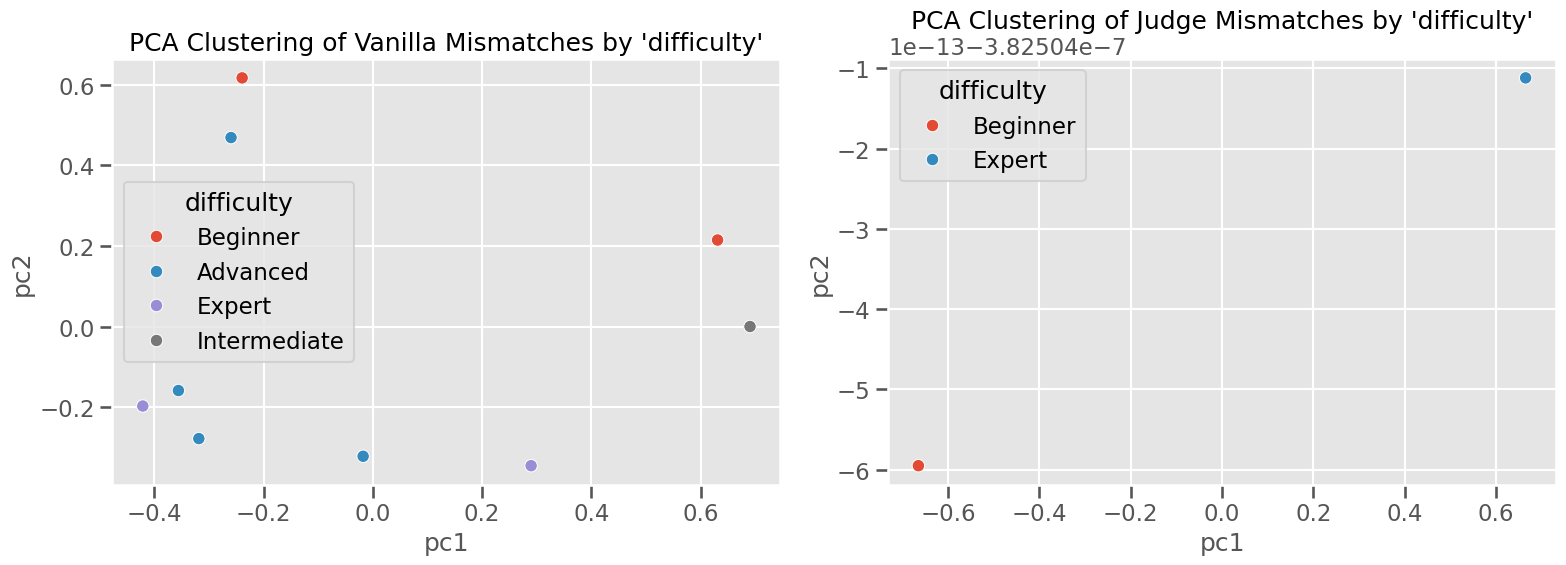

In [20]:
cluster_analysis_dual_pca(mismatches["vanilla"], mismatches["judge"], metadata_col="difficulty")